<a href="https://colab.research.google.com/github/lisamadeddu/lisa-PRA3024/blob/main/LM_ML_cifar_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [ ]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


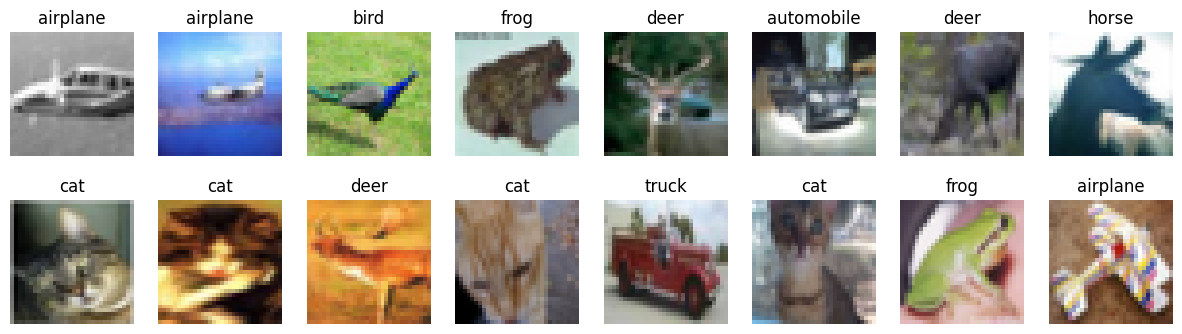

In [ ]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [ ]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network.
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.

    # -----------------------------------------------------
    # 1st convolutional block: learns basic low-level features
    # -----------------------------------------------------
    # uses 64 filters with a size of 3x3
    # padding='same' makes sure spaital dimensions for input and output are the same
    # 'input_shape=x_train.shape[1:] sets input dimensions based on training data (ChatGPT)
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    # ReLU introduces non-linearity
    model.add(Activation('relu'))
    # BatchNormalization normalizes activatons from previous layer to help speed up training (ChatGPT)
    model.add(BatchNormalization())

    # add second conv2D layer with same parameters to extract more low-level features to optimize
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # MaxPooling downsamples feature maps by taking max value in 2x2 window,
    # reducing spatial dimensions and computation while keeping most important features
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dropout randomly sets 40% of neurons to zero during training to reduce overfitting (ChatGPT)
    model.add(Dropout(0.40))

    # -----------------------------------------------------
    # 2nd convolutional block: learns more complex features
    # -----------------------------------------------------
    # increase number of filters to 128 to capture more complex patterns
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # deepen feature extraction by repeating another convolution
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.40))

    # -----------------------------------------------------
    # 3rd convolutional block: learns high-level features
    # -----------------------------------------------------
    # increase filter count to 256 to learn even more complex patterns
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # add another convolution layer
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.40))

    # -----------------------------------------------------
    # fully connected block: combines extracted features for classification
    # -----------------------------------------------------
    # flatten 2D feature maps into 1D feature vector for connected layers
    model.add(Flatten())
    # add dense layer with 512 neurons to learn non-linear combinations
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # prevent overfitting by randomly disabling half of the neurons in this layer
    model.add(Dropout(0.50))

    # -----------------------------------------------------
    # output layer: produces class probabilities
    # -----------------------------------------------------
    # final layer has 10 neurons, one for each CIFAR-10 class
    model.add(Dense(10))

    # Ensure normalized probabilities over the 10 classes
    # softmax converts output into probability distribution across 10 classes
    model.add(Activation("softmax"))

    return model

The model is designed using three convolutional blocks, with each increasing the number of filters in order to capture more complex and abstract features. Each convolution layer contains batch normalization, which stabilizes training and improves learning rates. ReLU is also used to introduce non-linearity, allowing the network to learn complex relationships in the data. Each block also contains a dropout to prevent overfitting. After flattening feature maps, a fully connected block with 512 neurons is used to combine the features learned in each block. A higher dropout rate is used in the fully connected block due to the higher number of parameters in that layer compared to the individual convolutional layers.

In [ ]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

# set parameters for training the network
INIT_LR = 5e-3  # initial learning rate: starting with high learning rate allows for faster initial learning
BATCH_SIZE = 128
EPOCHS = 25 # training set passes through network 25 times


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Nadam(learning_rate=INIT_LR),
    # using Nadam optimizer (ChatGPT) for better convergence and generalization
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # input images and labels
    batch_size=BATCH_SIZE, # defines number of samples to process before updating weights
    epochs=EPOCHS, # defines total number of passes throguh training dataset
    validation_data=(x_val, y_val), # used to evaluate model performance
    shuffle=True, # training data is randomly shuffled to improve learning
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.3629 - loss: 2.0605 - val_accuracy: 0.3756 - val_loss: 1.9575
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6191 - loss: 1.0829 - val_accuracy: 0.6341 - val_loss: 1.1752
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7021 - loss: 0.8449 - val_accuracy: 0.7466 - val_loss: 0.7250
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7541 - loss: 0.7076 - val_accuracy: 0.7632 - val_loss: 0.7004
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7808 - loss: 0.6232 - val_accuracy: 0.7534 - val_loss: 0.7448
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8043 - loss: 0.5529 - val_accuracy: 0.7857 - val_loss: 0.6635
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8267 - loss: 0.4962 - val_accuracy: 0.8098 - val_loss: 0.5849
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8391 - loss: 0.4621 - 

The training setup uses an initial learning rate of 0.005 to allow the network to learn relatively quickly at the initial stage. The batch size is set to 128 to increase the efficiency and stability of gradient upgrades, while the epochs are set to 25 to provide enough iterations for the network to learn from the data. The Nadam optimizer, which combines Adam with Nesterov momentum, was chosen due to its improved convergence and generalization.

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


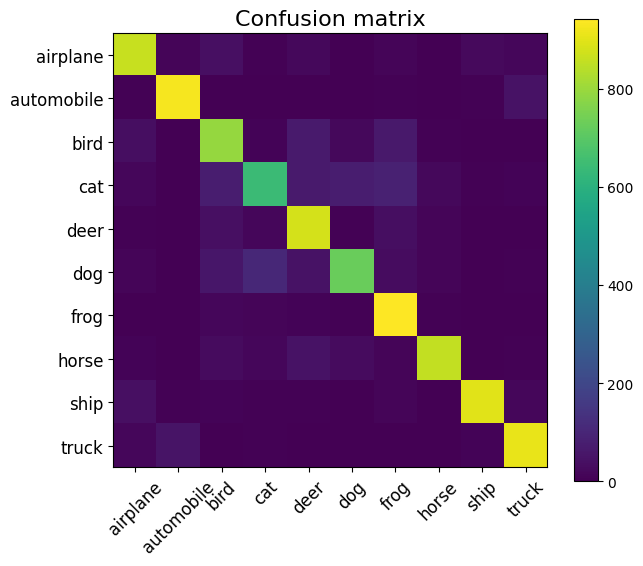

Test accuracy: 0.8434


In [ ]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

The confusion matrix represents how the model's predictions compare to the true labels for each of the 10 CIFAR classes. The diagonal cells show the number of samples correctly classified for each class, while the squares off the diagonal indicate misclassifications.

Most values along the diagonal are above 600, indicating a relatively high accuracy. The automobile, cat, frog, ship, and truck appear to have the most accuracy, while the bird and deer have the least.

The brighter off-diagonal cells show when the model confuses one class for another. For example, the bright square in the cat row and dog column show that cats are sometimes misclassified as dogs.

Overall, the test accuracy appeared to be relatively high (84.34%), indicating overall strong model performance.

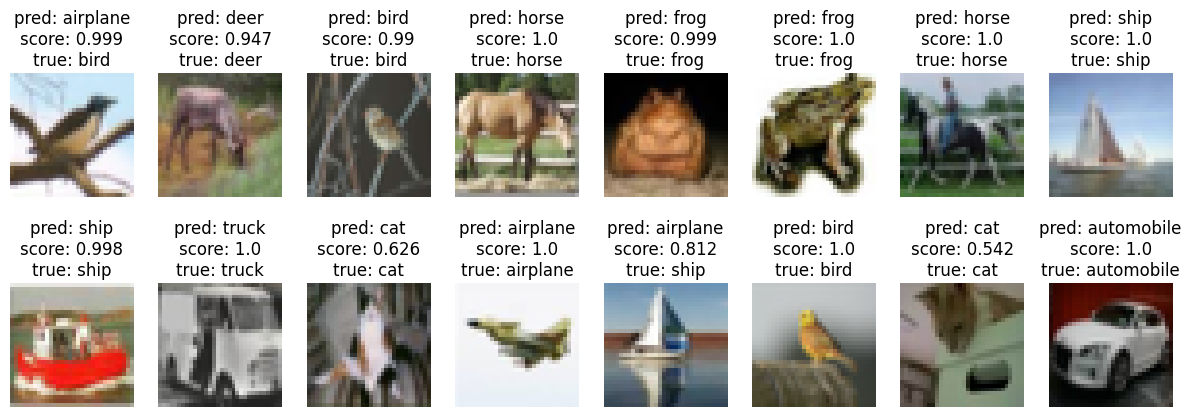

In [ ]:
# inspect predictions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

Most images  have matching predictions and true labels, showing that the model was mostly accurate at predicting the image classes. Only the bird and ship were incorrectly predicted by the model. Overall, most images have a high score, indicating strong model confidence. However, the incorrect images also had a relatively high score, indicating model overconfidence in certain scenarios.

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




**Iteration path report**:
1. Initial baseline: begins with a small CNN with two convlutional blocks and minimzal regularization. This achieved only about 70% accuracy.
2. Added third convolutional block: increased model depth and number of filters to capture more complex features. Accuracy improved to about 80%.
3. Changed optimizer: switched from Adam to Nadam for better convergence, leading to about 82% accuracy.
4. Small additional adjustments: increased epochs and batch size to final amount, leading to final accuracy of 84.34%.